# Agent design with Bayesian Network

## Importing libraries

In [75]:
import itertools
import time
import random
import matplotlib.pyplot as plt
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination, BeliefPropagation

## Setting parameters

In [57]:
diff = 0.6  # difficulty associated to target, 0-1
fail_def = 0.001  # Default prob of failure, 0-1
sensors = [1.5, 2, 2.5]  # distance measured from sensors, metres
max_sense = 3  # Max distance for sensor, metres...at least 6 times bigger than s
s = 0.5 # safe area around agent, metres

## Computes sensor probabilities from parameters

In [58]:
failure_sens = []
for i in range(len(sensors)):
  failure_sens.append((1 - (sensors[i] - s)/max_sense)**3 if sensors[i] > s else 1)  # Probability of collision for sensor i
  print("Probability of collision for sensor", i, ":", failure_sens[-1])

Probability of collision for sensor 0 : 0.2962962962962964
Probability of collision for sensor 1 : 0.125
Probability of collision for sensor 2 : 0.03703703703703705


## Model

### Creating edges

In [59]:
edges = [('Fo', 'F'),
        ('Fd', 'F'),
        ('D', 'G'),
        ('F', 'G')]
for i in range(len(sensors)):
  edges.append(('F'+str(i), 'Fo'))

### Creating model

In [60]:
agent_succ_model = BayesianModel(edges)

### Creating tables

#### Creating combinations and their probabilities

In [61]:
def create_combinations(n):
        """
        Creates all possible combinations of sensors 0..n-1.
        @:return List of tuples, where each tuple has a list (combination of sensors) and the probability associated
        """
        combs = []
        goals = list(range(n))
        for i in range(1, n+1):
            combs += ([(x, len(x)*0.95/n)for x in itertools.combinations(goals, i)])
        return combs

In [62]:
# Constant tables (no sensor)
cpd_d = TabularCPD(variable='D', variable_card=2, values=[[1-diff], [diff]])  # Target difficulty
cpd_fd = TabularCPD(variable='Fd', variable_card=2, values=[[1-fail_def], [fail_def]])  # Default Failure
cpd_f = TabularCPD(variable='F', variable_card=2, values=[[1, 0, 0.01, 0],  # Total Failure
                                                          [0, 1, 0.99, 1]],
                   evidence=['Fo', 'Fd'],
                   evidence_card=[2, 2])
cpd_go = TabularCPD(variable='G', variable_card=2,  # Goal or Stop
                        values=[[0.0, 1.0, 0.5, 1.0],
                                [1.0, 0.0, 0.5, 0.0]],
                        evidence=['D', 'F'],
                        evidence_card=[2, 2])
cpds = [cpd_d, cpd_fd, cpd_f, cpd_go]

# Tables associated to sensors
for i in range(len(sensors)):
  cpds.append(TabularCPD(variable='F'+str(i), variable_card=2, values=[[1-failure_sens[i]], [failure_sens[i]]]))

# Creating obstacle failure from sensors failures
false_probs = [1]  # All sensors free
combs_prob = create_combinations(len(sensors))  # Noisy-OR
for comb in combs_prob:
  false_probs.append(1-comb[1])
cpd_fo = TabularCPD(variable='Fo', variable_card=2, values=[false_probs,   # Obstacle Failure
                                                            [1-x for x in false_probs]],
                    evidence=['F'+str(i) for i in range(len(sensors))],
                    evidence_card=[2 for i in range(len(sensors))])
cpds.append(cpd_fo)

### Adding tables to model and checking if they are valid

In [63]:
for cpd in cpds:
  agent_succ_model.add_cpds(cpd)

if agent_succ_model.check_model():
  print("Cpds and model valid.")
else:
  print("Cpds and model not valid.")

Cpds and model valid.


### Showing cpds

In [64]:
for i in range(len(sensors)):
    print("Cpd for Failure Obstacle ", str(i), "\n", agent_succ_model.get_cpds('F'+str(i)))
print("Cpd for Difficulty\n", agent_succ_model.get_cpds('D'))
print("Cpd for Default Failure\n", agent_succ_model.get_cpds('Fd'))
print("Cpd for Obstacles Failure\n", agent_succ_model.get_cpds('Fo'))
print("Cpd for Total Failure\n", agent_succ_model.get_cpds('F'))
print("Cpd for Stop\n", agent_succ_model.get_cpds('G'))

Cpd for Failure Obstacle  0 
 +-------+----------+
| F0(0) | 0.703704 |
+-------+----------+
| F0(1) | 0.296296 |
+-------+----------+
Cpd for Failure Obstacle  1 
 +-------+-------+
| F1(0) | 0.875 |
+-------+-------+
| F1(1) | 0.125 |
+-------+-------+
Cpd for Failure Obstacle  2 
 +-------+----------+
| F2(0) | 0.962963 |
+-------+----------+
| F2(1) | 0.037037 |
+-------+----------+
Cpd for Difficulty
 +------+-----+
| D(0) | 0.4 |
+------+-----+
| D(1) | 0.6 |
+------+-----+
Cpd for Default Failure
 +-------+-------+
| Fd(0) | 0.999 |
+-------+-------+
| Fd(1) | 0.001 |
+-------+-------+
Cpd for Obstacles Failure
 +-------+-------+---------------------+---------------------+---------------------+--------------------+--------------------+--------------------+----------------------+
| F0    | F0(0) | F0(0)               | F0(0)               | F0(0)               | F0(1)              | F0(1)              | F0(1)              | F0(1)                |
+-------+-------+----------------

## Performing inference

### Belief Propagation

In [79]:
bp = BeliefPropagation(agent_succ_model)
bp.calibrate()

### Variable Elimination

In [80]:
agent_succ_infer = VariableElimination(agent_succ_model)

### Testing times

In [81]:
avg_ve = 0.0
avg_bp = 0.0
# Computing the probability of stop.
start_time = time.time()
q = agent_succ_infer.query(variables=['G'], show_progress=False)
avg_ve += time.time() - start_time
print("Probability of stop\n", q, "\n")

start_time = time.time()
q = bp.query(variables=['G'], show_progress=False)
avg_bp += time.time() - start_time

# Probability of failure obstacles given stop.
start_time = time.time()
q = agent_succ_infer.query(variables=['Fo'], evidence={'G': 1}, show_progress=False)
avg_ve += time.time() - start_time
print("Probability of failure obstacles given G: 1\n", q, "\n")

start_time = time.time()
q = bp.query(variables=['Fo'], evidence={'G': 1}, show_progress=False)
avg_bp += time.time() - start_time

# Probability of failure obstacles given stop and difficulty.
start_time = time.time()
q = agent_succ_infer.query(variables=['Fo'], evidence={'G': 1, 'D': 1}, show_progress=False)
avg_ve += time.time() - start_time
print("Probability of failure obstacles given G: 1 and D:1\n", q, "\n")

start_time = time.time()
q = bp.query(variables=['Fo'], evidence={'G': 1, 'D': 1}, show_progress=False)
avg_bp += time.time() - start_time

# Probability of stop given failure obstacles.
start_time = time.time()
q = agent_succ_infer.query(variables=['G'], evidence={'Fo': 1}, show_progress=False)
avg_ve += time.time() - start_time
print("Probability of stop given Fo: 1\n", q, "\n")

start_time = time.time()
q = bp.query(variables=['Fo'], evidence={'G': 1, 'D': 1}, show_progress=False)
avg_bp += time.time() - start_time

# Computing the joint probability of failure obstacles and difficulty given G: 0
start_time = time.time()
q = agent_succ_infer.query(variables=['Fo', 'D'], evidence={'G': 0}, show_progress=False)
avg_ve += time.time() - start_time
print("Joint Probability of failure obstacles and difficulty given G: 0\n", q, "\n")

start_time = time.time()
q = bp.query(variables=['Fo'], evidence={'G': 1, 'D': 1}, show_progress=False)
avg_bp += time.time() - start_time

Probability of stop
 +------+----------+
| G    |   phi(G) |
+======+==========+
| G(0) |   0.4552 |
+------+----------+
| G(1) |   0.5448 |
+------+----------+ 

Probability of failure obstacles given G: 1
 +-------+-----------+
| Fo    |   phi(Fo) |
+=======+===========+
| Fo(0) |    0.9971 |
+-------+-----------+
| Fo(1) |    0.0029 |
+-------+-----------+ 

Probability of failure obstacles given G: 1 and D:1
 +-------+-----------+
| Fo    |   phi(Fo) |
+=======+===========+
| Fo(0) |    0.9971 |
+-------+-----------+
| Fo(1) |    0.0029 |
+-------+-----------+ 

Probability of stop given Fo: 1
 +------+----------+
| G    |   phi(G) |
+======+==========+
| G(0) |   0.9930 |
+------+----------+
| G(1) |   0.0070 |
+------+----------+ 

Joint Probability of failure obstacles and difficulty given G: 0
 +------+-------+-------------+
| D    | Fo    |   phi(D,Fo) |
+======+=======+=============+
| D(0) | Fo(0) |      0.0007 |
+------+-------+-------------+
| D(0) | Fo(1) |      0.1941 |


In [82]:
print("Avg time for variable elimination: ", avg_ve / 5)
print("Avg time for belief propagation: ", avg_bp / 5)
print("Difference (avg_ve - avg_bp): ", (avg_ve - avg_bp) / 5)

Avg time for variable elimination:  0.018680715560913087
Avg time for belief propagation:  0.011329746246337891
Difference (avg_bp - avg_ve):  0.0073509693145751955


## Plots

In [83]:
num_tests_sensors = 100  # Number of time to draw sensors readings

In [84]:
def all_togheter(diff, fail_def, sensors, max_sense, s):
    failure_sens = []
    for i in range(len(sensors)):
        failure_sens.append((1 - (sensors[i] - s)/max_sense)**3 if sensors[i] > s else 1)
    # Constant tables (no sensor)
    cpd_d = TabularCPD(variable='D', variable_card=2, values=[[1-diff], [diff]])  # Target difficulty
    cpd_fd = TabularCPD(variable='Fd', variable_card=2, values=[[1-fail_def], [fail_def]])  # Default Failure
    cpd_f = TabularCPD(variable='F', variable_card=2, values=[[1, 0, 0.01, 0],  # Total Failure
                                                              [0, 1, 0.99, 1]],
                       evidence=['Fo', 'Fd'],
                       evidence_card=[2, 2])
    cpd_go = TabularCPD(variable='G', variable_card=2,  # Goal or Stop
                            values=[[0.0, 1.0, 0.5, 1.0],
                                    [1.0, 0.0, 0.5, 0.0]],
                            evidence=['D', 'F'],
                            evidence_card=[2, 2])
    cpds = [cpd_d, cpd_fd, cpd_f, cpd_go]

    # Tables associated to sensors
    for i in range(len(sensors)):
        cpds.append(TabularCPD(variable='F'+str(i), variable_card=2, values=[[1-failure_sens[i]], [failure_sens[i]]]))

    # Creating obstacle failure from sensors failures
    false_probs = [1]  # All sensors free
    combs_prob = create_combinations(len(sensors))  # Noisy-OR
    for comb in combs_prob:
        false_probs.append(1-comb[1])
    cpd_fo = TabularCPD(variable='Fo', variable_card=2, values=[false_probs,   # Obstacle Failure
                                                                [1-x for x in false_probs]],
                        evidence=['F'+str(i) for i in range(len(sensors))],
                        evidence_card=[2 for i in range(len(sensors))])
    cpds.append(cpd_fo)
    for cpd in cpds:
        agent_succ_model.add_cpds(cpd)
        
    return VariableElimination(agent_succ_model)

### Diff vs Goal

In [45]:
fail_def = 0.001
max_sense = 3
s = 0.5

diff_values = [float(diff)/100 for diff in range(0, 100, 5)]
goals = []
for diff in diff_values:
    tmp_mean = 0
    for i in range(num_tests_sensors):
        sensors = [random.random()*max_sense, random.random()*max_sense, random.random()*max_sense]
        agent_succ_infer = all_togheter(diff, fail_def, sensors, max_sense, s)
        # Computing the probability of stop.
        q = agent_succ_infer.query(variables=['G'], show_progress=False)
        tmp_mean += q.values[1]
    goals.append(tmp_mean / num_tests_sensors)

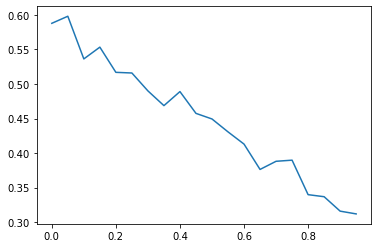

In [46]:
plt.plot(diff_values, goals)

### Fail def vs Goal

In [47]:
diff = 0.6
max_sense = 3
s = 0.5

fail_def_values = [float(fail_def)/100 for fail_def in range(0, 100, 5)]
goals = []
for fail_def in fail_def_values:
    tmp_mean = 0
    for i in range(num_tests_sensors):
        sensors = [random.random()*max_sense, random.random()*max_sense, random.random()*max_sense]
        agent_succ_infer = all_togheter(diff, fail_def, sensors, max_sense, s)
        # Computing the probability of stop.
        q = agent_succ_infer.query(variables=['G'], show_progress=False)
        tmp_mean += q.values[1]
    goals.append(tmp_mean / num_tests_sensors)

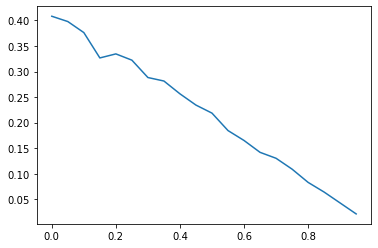

In [48]:
plt.plot(fail_def_values, goals)

### Max sense vs Goal

In [49]:
diff = 0.6
fail_def = 0.001
s = 0.5

max_sense_values = [max_sense for max_sense in range(int(6*s), int(6*s)+5)]  # Max sense should be at least 6 times S
goals = []
for max_sense in max_sense_values:
    tmp_mean = 0
    for i in range(num_tests_sensors):
        sensors = [random.random()*max_sense, random.random()*max_sense, random.random()*max_sense]
        agent_succ_infer = all_togheter(diff, fail_def, sensors, max_sense, s)
        # Computing the probability of stop.
        q = agent_succ_infer.query(variables=['G'], show_progress=False)
        tmp_mean += q.values[1]
    goals.append(tmp_mean / num_tests_sensors)

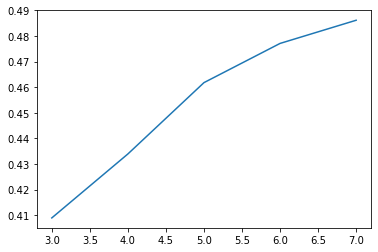

In [50]:
plt.plot(max_sense_values, goals)

### S vs Goal

In [55]:
diff = 0.6
fail_def = 0.001

s_values = [s/2 for s in range(1, 10)]
goals = []
for s in s_values:
    max_sense = 6*s  # Max sense should be at least 6 times S
    tmp_mean = 0
    for i in range(num_tests_sensors):
        sensors = [random.random()*max_sense, random.random()*max_sense, random.random()*max_sense]
        agent_succ_infer = all_togheter(diff, fail_def, sensors, max_sense, s)
        # Computing the probability of stop.
        q = agent_succ_infer.query(variables=['G'], show_progress=False)
        tmp_mean += q.values[1]
    goals.append(tmp_mean / num_tests_sensors)

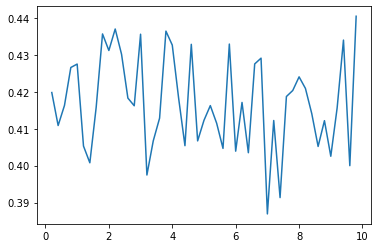

In [56]:
plt.plot(s_values, goals)